Import necessary libaries

In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import LabelEncoder
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
import re
from unidecode import unidecode
import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_validate,learning_curve,cross_val_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import SGDClassifier,SGDRegressor,LogisticRegression
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/natedrake7/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Pre-Processing

In [2]:
#Read csv files
train_data = pd.read_csv('./Data/train_set.csv')
test_data = pd.read_csv('./Data/test_set.csv')

#Create Dataframes
train_set = pd.DataFrame(train_data)
test_set = pd.DataFrame(test_data)

#Drop Party and New ID columns since we dont need them
labels_to_drop = ['Party','New_ID']
train_set = train_set.drop(columns=labels_to_drop)
test_set = test_set.drop(columns=labels_to_drop)

#Make all text lowercase
train_set['Text'] = train_set['Text'].str.lower()
test_set['Text'] = test_set['Text'].str.lower()

#Remove accents from all text
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return ''.join([c for c in nfkd_form if not unicodedata.combining(c)])

train_set['Text'] = train_set['Text'].apply(remove_accents)
test_set['Text'] = test_set['Text'].apply(remove_accents)

#Remove stopwords and replace them with a single space
stop = stopwords.words('greek')
pat = r'\b(?:{})\b'.format('|'.join(stop))

train_set['Text'] = train_set['Text'].str.replace(pat,'',regex=True)
test_set['Text'] = test_set['Text'].str.replace(pat,'',regex=True)

#Remove multiple white spaces and replace them with a single space
train_set['Text'] = train_set['Text'].str.replace(r'\s+',' ',regex=True) #remove multiple whitespaces
test_set['Text'] = test_set['Text'].str.replace(r'\s+',' ',regex=True) #remove multiple whitespaces

#Remove links and replace them with a single space
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)) #remove links
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)) #remove links

#Replace non greek words with single whitespace
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub(r'[^α-ωΑ-Ω0-9\s]', ' ', x, flags=re.UNICODE))      
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub(r'[^α-ωΑ-Ω0-9\s]', ' ', x, flags=re.UNICODE))

#Find retweets and replace them withn single whitespace
train_set['Text'] = train_set['Text'].apply(lambda x: re.sub(r'^RT[\s]+', '', x))
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub(r'^RT[\s]+', '', x))

#Load lemmatizer
nlp = spacy.load("el_core_news_sm")

def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    return lemmatized_text

#Lemmatize text to replace words with their dictionary value
train_set['Text'] = train_set['Text'].apply(lemmatize_text)
test_set['Text'] = test_set['Text'].apply(lemmatize_text)


Save Pre Processed Dataframe

In [5]:
train_set.to_csv('processed_df')
test_set.to_csv('processed_test')

Read Pre Processed Dataframe

In [6]:
data = pd.read_csv('processed_df')
train_set = pd.DataFrame(data)

data = pd.read_csv('processed_test')
test_set = pd.DataFrame(data)

Vectorization and Label Encoding

In [8]:
vectorizer = CountVectorizer()
encoder = LabelEncoder()

#train_set = train_set.head(10000)


X_train = vectorizer.fit_transform(train_set['Text'])
X_test = vectorizer.fit_transform(test_set['Text'])

Y_train = encoder.fit_transform(train_set['Sentiment'])

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3)

Classification:

F1 Score Train: 1.0
F1 Score Validation: 0.2329402863529529
F1 Score Train: 0.988798872146125
F1 Score Validation: 0.3514023583158809
F1 Score Train: 0.9807877932909443
F1 Score Validation: 0.35901060903724796
F1 Score Train: 0.973175770460373
F1 Score Validation: 0.3642578214285091
F1 Score Train: 0.9645011201263978
F1 Score Validation: 0.35478692945569984
F1 Score Train: 0.9539179499275107
F1 Score Validation: 0.36602800473589875
F1 Score Train: 0.9474993145159575
F1 Score Validation: 0.35856759257053417
F1 Score Train: 0.9346402019583901
F1 Score Validation: 0.3639862341421231
F1 Score Train: 0.9314497045811545
F1 Score Validation: 0.36786439083584754
F1 Score Train: 0.9230133623167461
F1 Score Validation: 0.3733058749304932
0.95977840893236
0.34921501018051876


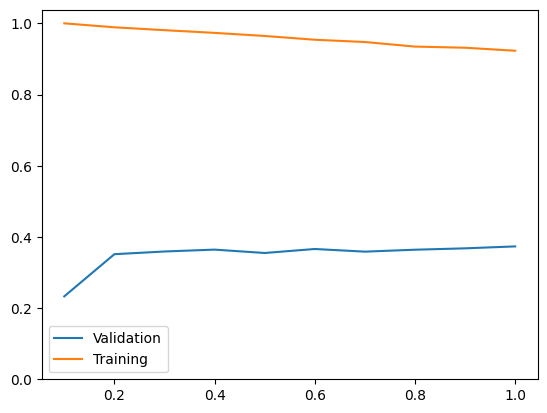

In [9]:
list_f1=[]
list_f1_train=[]
list_sample_size=[]

for times in range(10):
  # training
  #
  X, X_unused, y, y_unused = train_test_split(X_train, Y_train, test_size=1 - (times * 0.1 + 0.001))

  classifier = LogisticRegression(max_iter=2000,C=10.0,multi_class='auto',solver='lbfgs')
  #classifier = SGDClassifier(loss='log_loss',penalty='elasticnet',alpha=1e-5,max_iter=2000,early_stopping = True)
  classifier.fit(X, np.ravel(y))

  results_train = classifier.predict(X)

  # validation
  #
  results = classifier.predict(X_val)

  # score
  #
  f1_train = f1_score(y, results_train,average='weighted')
  print("F1 Score Train: " + str(f1_train))

  f1 = f1_score(Y_val, results,average='weighted')
  print("F1 Score Validation: " + str(f1))

  list_f1.append(f1)
  list_f1_train.append(f1_train)
  list_sample_size.append((times * 0.1 + 0.1))

plt.plot(list_sample_size, list_f1)
plt.plot(list_sample_size, list_f1_train)

plt.ylim(ymin=0)
plt.legend(["Validation", "Training"])

print(sum(list_f1_train) / len(list_f1_train))
print(sum(list_f1) / len(list_f1))

Logistic Regression Classifier

$
\begin{array}{|c|c|c|c|c|c|}
\hline
\text{Penalty} & \text{C} & \text{Multi Class} & \text{Max Iterations} & \text{Solver} & \text{Avg F1-Score}\\
\hline
\text{L2} & \text{1.0} & \text{auto} & \text{100} & \text{lbfgs} & \text{34.8\%}\\
\hline
\text{L2} & \text{1.0} & \text{auto} & \text{500} & \text{lbfgs} & \text{35.7\%}\\
\hline
\text{L2} & \text{1.0} & \text{auto} & \text{1000} & \text{lbfgs} & \text{35.8\%}\\
\hline
\text{L2} & \text{1.0} & \text{auto} & \text{1000} & \text{lbfgs} & \text{35.6\%}\\
\hline
\text{L2} & \text{1.0} & \text{auto} & \text{2000} & \text{lbfgs} & \text{36.2\%}\\
\hline
\text{L2} & \text{0.1} & \text{auto} & \text{2000} & \text{lbfgs} & \text{36.1\%}\\
\hline
\text{L2} & \text{5.0} & \text{auto} & \text{2000} & \text{lbfgs} & \text{35.7\%}\\
\hline
\text{L2} & \text{10.0} & \text{auto} & \text{2000} & \text{lbfgs} & \text{35.8\%}\\
\hline
\text{L2} & \text{20.0} & \text{auto} & \text{2000} & \text{lbfgs} & \text{34.9\%}\\
\hline
\text{L2} & \text{100.0} & \text{auto} & \text{2000} & \text{lbfgs} & \text{35.2\%}\\
\hline
\end{array}
$
C > 10.0 ,really great f1 training values > 0.95 but really long time to execute.
C = 100.0 took : 4 minutes 32.8 seconds with avg training f1: 96.4% but only 35.2% avg f1 test.

Logistic Regression with SGD

$
\begin{array}{|c|c|c|c|c|c|}
\hline
\text{Penalty} & \text{C} & \text{Multi Class} & \text{Max Iterations} & \text{Solver} & \text{Avg F1-Score}\\
\hline
\text{L2} & \text{1.0} & \text{auto} & \text{100} & \text{lbfgs} & \text{36.0\%}\\
\hline
\text{L2} & \text{1.0} & \text{auto} & \text{500} & \text{lbfgs} & \text{35.7\%}\\
\hline
\text{L2} & \text{1.0} & \text{auto} & \text{1000} & \text{lbfgs} & \text{35.8\%}\\
\hline
\text{L2} & \text{1.0} & \text{auto} & \text{1000} & \text{lbfgs} & \text{35.6\%}\\
\hline
\end{array}
$